In [ ]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [ ]:
# Set visibible GPU
gpu_num: int = 1
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory, get_gpu_device
gpu_grow_memory(verbose=True)

In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = False
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [9]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [10]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
0,0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976,False
1,1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393,False
2,2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691,False
3,3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181,False
4,4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697957,5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246,False
5697958,5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382,False
5697959,5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200,False
5697960,5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274,False


In [11]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [12]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,2.544333,0.209350,-0.341241,0.106091,4.521271,2.275609,58600.0,1611,405.620375,10.105830
1,1,3.022120,0.388701,2.045759,0.091330,4.833602,0.818635,58600.0,1210,331.403807,9.527190
2,2,2.658252,0.084018,-0.200892,0.054430,3.919254,3.036481,58600.0,1482,296.036045,7.689896
3,3,3.173817,0.119381,0.065729,0.101663,3.854650,3.433540,58600.0,878,248.403326,8.383206
4,4,2.558488,0.247786,-0.754779,0.065962,3.944458,3.127290,58600.0,1550,202.217491,5.136329
...,...,...,...,...,...,...,...,...,...,...,...
59,59,3.180329,0.144169,-0.069335,0.095246,0.084546,0.175799,58600.0,881,54.676130,1.842086
60,60,3.191399,0.080179,1.912886,0.080646,2.185491,3.813534,58600.0,478,54.236576,2.480723
61,61,2.349225,0.200286,2.068264,0.096268,1.322709,5.337065,58600.0,122,53.581222,4.851016
62,62,3.154451,0.081705,-4.248868,0.304007,2.652238,2.144825,58600.0,434,53.002095,2.544182


## Batches of ZTF Data Near Initial Candidate Elements

In [13]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [14]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [15]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,9472,0,b'ZTF18ablreca',582228440915015051,4429,58336.228449,275.623971,-19.732784,0.092245,-0.993751,...,0.063652,-0.994811,0.079366,1.669246,0.033041,6815.410019,0.999454,0.896032,False,False
1,9523,0,b'ZTF18ablrrmm',582228441515010169,4429,58336.228449,274.474165,-20.557661,0.073042,-0.996118,...,0.063652,-0.994811,0.079366,1.669246,0.031681,6534.850780,0.999498,0.823785,False,False
2,9524,0,b'ZTF18ablrrmm',583325941515010039,4533,58337.325949,274.474106,-20.557585,0.073041,-0.996118,...,0.061522,-0.994926,0.079609,1.676021,0.032596,6723.784176,0.999469,0.872104,False,False
3,83268,0,b'ZTF18abkiuvs',583325941515015015,4533,58337.325949,274.254244,-20.690837,0.069398,-0.996485,...,0.061522,-0.994926,0.079609,1.676021,0.033655,6942.119800,0.999434,0.929656,False,False
4,83271,0,b'ZTF18abkiuvs',582228441515015011,4429,58336.228449,274.254253,-20.690856,0.069398,-0.996485,...,0.063652,-0.994811,0.079366,1.669246,0.032988,6804.644809,0.999456,0.893204,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47351,5244546,63,b'ZTF20aanbicp',1139161934315015010,93033,58893.161933,37.471372,19.129852,0.749830,0.657697,...,0.748948,0.654175,0.105506,2.518142,0.033664,6944.105315,0.999433,0.930188,False,False
47352,5381276,63,b'ZTF18abomwia',1142181624015015000,94184,58896.181620,36.733350,20.616292,0.750104,0.653657,...,0.737167,0.667517,0.104914,2.561837,0.019494,4020.896645,0.999810,0.311897,False,False
47353,5381393,63,b'ZTF20aaogfkm',1142181623915015001,94184,58896.181620,39.193902,19.790850,0.729236,0.680236,...,0.737167,0.667517,0.104914,2.561837,0.034247,7064.277329,0.999414,0.962658,False,False
47354,5445787,63,b'ZTF20aapczfl',1145109243715015002,94770,58899.109248,38.029908,20.665282,0.737008,0.669246,...,0.725274,0.680505,0.104353,2.603903,0.019017,3922.518773,0.999819,0.296822,False,False


In [16]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [17]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [18]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [19]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :    47356   (      740)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     105.28
Sqrt(batch_obs):      27.20
Mean t_score   :       4.36


In [21]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,2.544333,0.209350,-0.341241,0.106091,4.521271,2.275609,58600.0,1611,405.620375,10.105830,10,0.008727,0.034905,16.5,4.0
1,1,3.022120,0.388701,2.045759,0.091330,4.833602,0.818635,58600.0,1210,331.403807,9.527190,10,0.008727,0.034905,16.5,4.0
2,2,2.658252,0.084018,-0.200892,0.054430,3.919254,3.036481,58600.0,1482,296.036045,7.689896,10,0.008727,0.034905,16.5,4.0
3,3,3.173817,0.119381,0.065729,0.101663,3.854650,3.433540,58600.0,878,248.403326,8.383206,10,0.008727,0.034905,16.5,4.0
4,4,2.558488,0.247786,-0.754779,0.065962,3.944458,3.127290,58600.0,1550,202.217491,5.136329,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,3.180329,0.144169,-0.069335,0.095246,0.084546,0.175799,58600.0,881,54.676130,1.842086,10,0.008727,0.034905,16.5,4.0
60,60,3.191399,0.080179,1.912886,0.080646,2.185491,3.813534,58600.0,478,54.236576,2.480723,10,0.008727,0.034905,16.5,4.0
61,61,2.349225,0.200286,2.068264,0.096268,1.322709,5.337065,58600.0,122,53.581222,4.851016,10,0.008727,0.034905,16.5,4.0
62,62,3.154451,0.081705,-4.248868,0.304007,2.652238,2.144825,58600.0,434,53.002095,2.544182,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [22]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [23]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [24]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_rand_unknown_{random_seed:04d}.h5',
                name='model')

In [25]:
# model.load()

In [26]:
# raise ValueError

In [27]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     3.33  :   0.00 :  1794.61 :  7200.00
Mean     :     3.33  :   0.00 :  1794.61 :  7200.00
Median   :     2.01  :   0.00 :  1792.82 :  7200.00
GeoMean  :     2.35  :   0.00 :  1794.61 :  7200.99
Min      :     0.62  :   0.00 :  1792.82 :  7200.00
Max      :    25.41  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


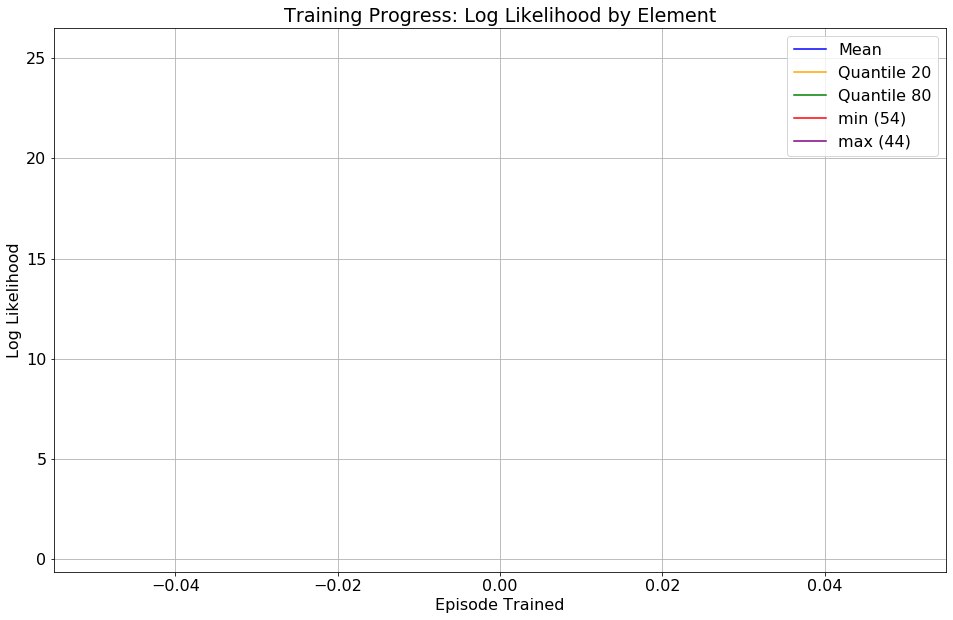

In [28]:
fig, ax = model.plot_hist(att_name='log_like', x_axis='episode')

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 4s 877us/sample - loss: -95.8885
Epoch 2/4
4096/4096 [==============================] - 1s 292us/sample - loss: -113.6768
Epoch 3/4
4096/4096 [==============================] - 1s 278us/sample - loss: -131.4979
Epoch 4/4
4096/4096 [==============================] - 1s 284us/sample - loss: -148.9208
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1291.33 :  1291.33 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      6.00 :     6.00 :      nan
Mean Hits           :      0.00 :     0.

/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


4096/4096 [==============================] - 1s 290us/sample - loss: -165.4590
Epoch 6/8
4096/4096 [==============================] - 1s 285us/sample - loss: -180.6448
Epoch 7/8
4096/4096 [==============================] - 1s 290us/sample - loss: -194.1229
Epoch 8/8
4096/4096 [==============================] - 1s 286us/sample - loss: -205.7165
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1191.89 :  1191.89 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      8.03 :     8.03 :      nan
Mean Hits           :      0.00 :     0.00 :      nan
Good Elements       :      0.00

********************************************************************************
Terminating: Completed 512 batches.
********************************************************************************

Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :  

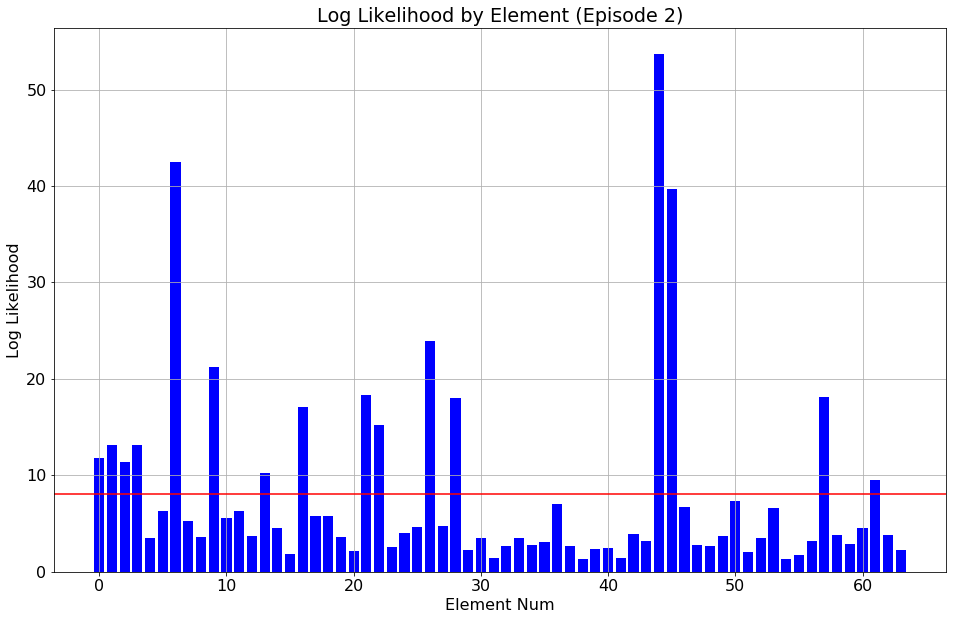

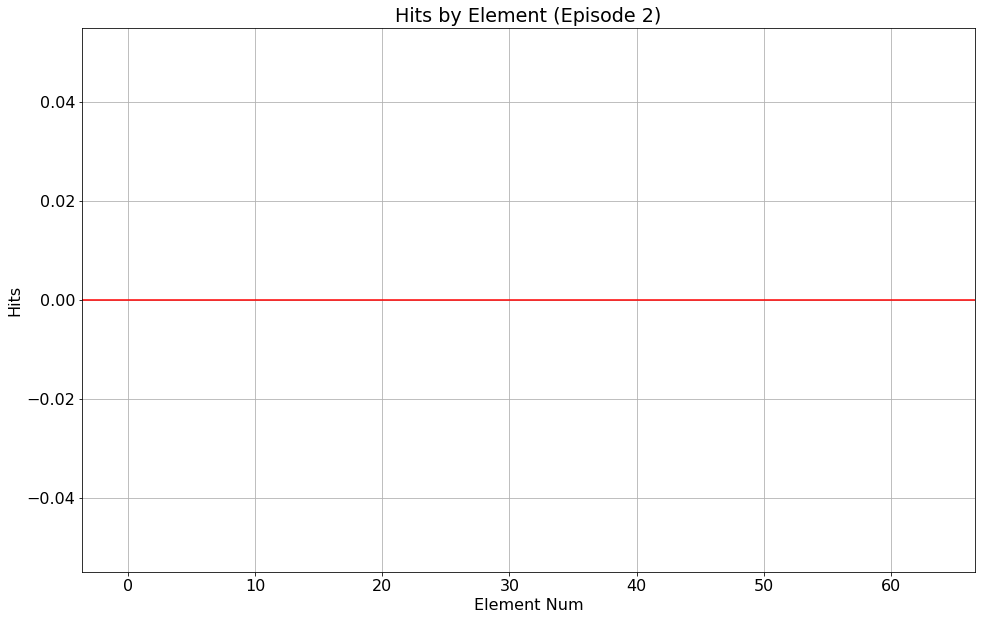


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.441e-04, training_time 22 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 5s 1ms/sample - loss: -351.0376
Epoch 10/12
4096/4096 [==============================] - 2s 394us/sample - loss: -428.0988
Epoch 11/12
4096/4096 [==============================] - 2s 390us/sample - loss: -467.7422
Epoch 12/12
4096/4096 [==============================] - 2s 391us/sample - loss: -493.1274
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1150.06 :  1150.06 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     18.37 :    18.37 : 

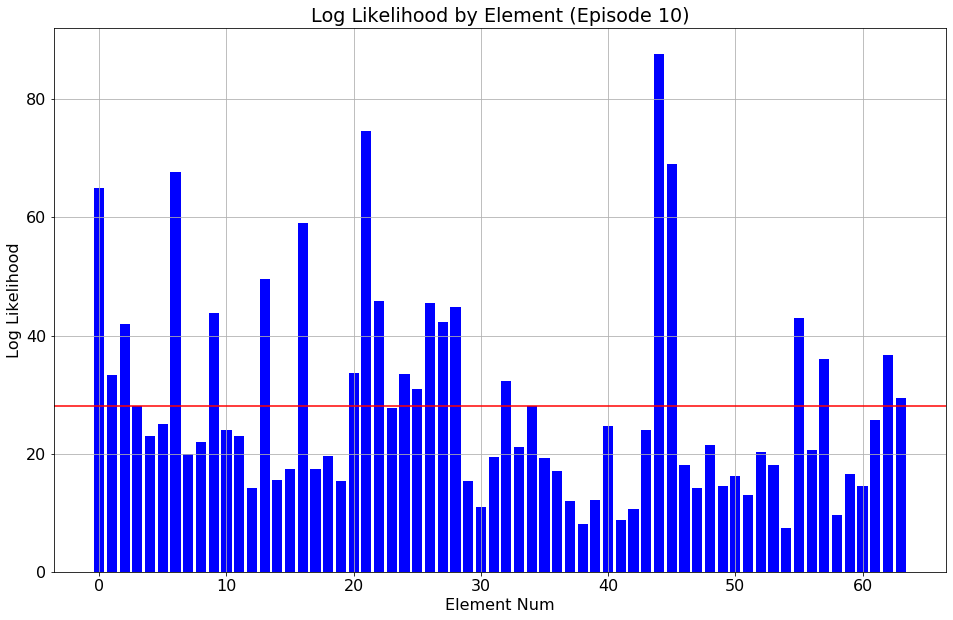

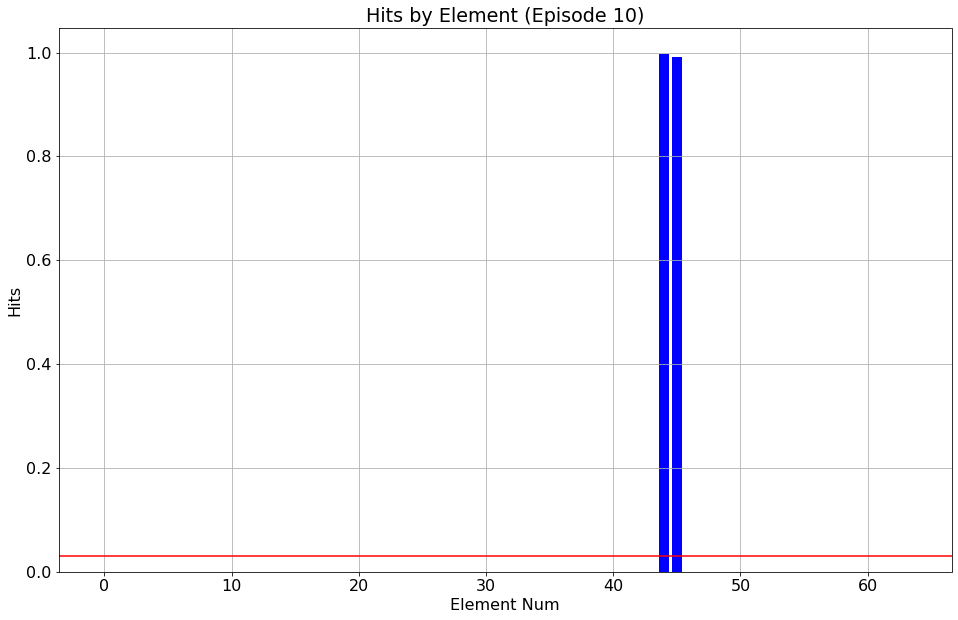


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 90 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 3s 812us/sample - loss: -583.7196
Epoch 42/44
4096/4096 [==============================] - 1s 300us/sample - loss: -649.6929
Epoch 43/44
4096/4096 [==============================] - 1s 312us/sample - loss: -707.6451
Epoch 44/44
4096/4096 [==============================] - 1s 316us/sample - loss: -757.8088
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    671.21 :   671.21 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      nan arc seconds
Mean Log Likelihood :     28.95 :    28.95 :      nan
Mean Hits           :      0.

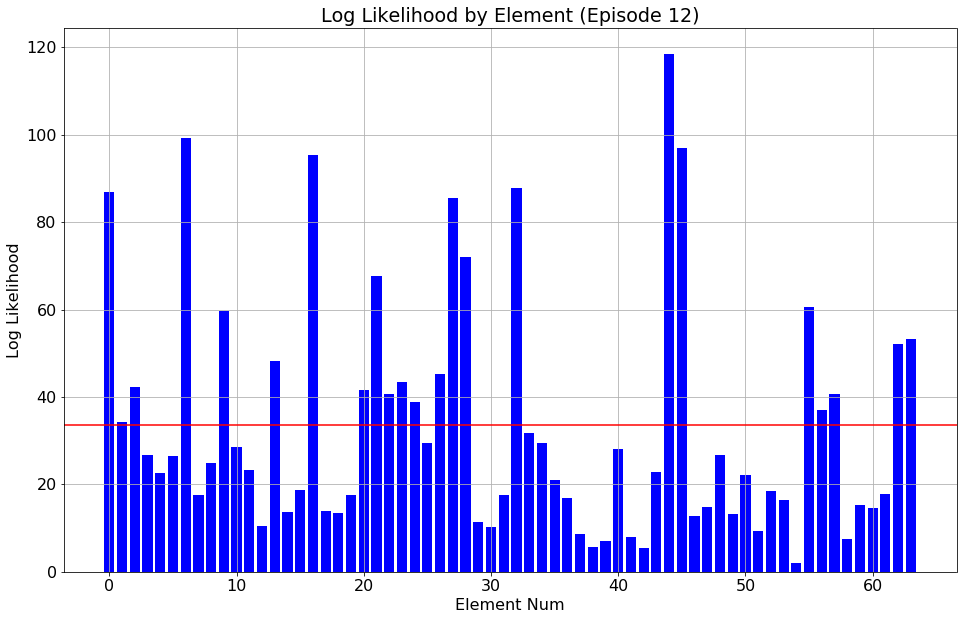

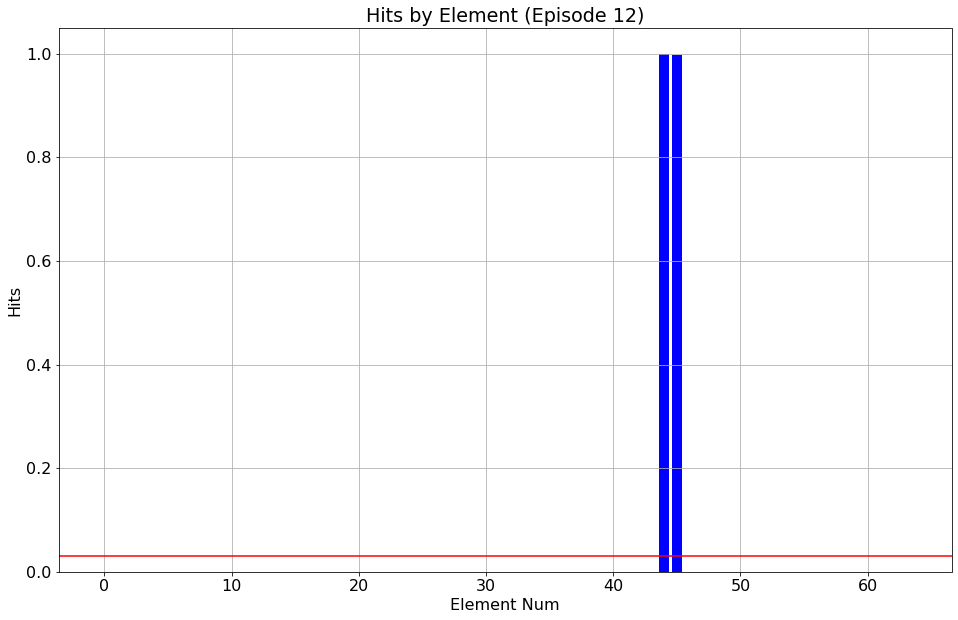


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=2.441e-04, training_time 106 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 5s 1ms/sample - loss: -961.4951
Epoch 50/52
4096/4096 [==============================] - 2s 436us/sample - loss: -977.4539
Epoch 51/52
4096/4096 [==============================] - 2s 427us/sample - loss: -987.2475
Epoch 52/52
4096/4096 [==============================] - 2s 422us/sample - loss: -995.2111
Adjusted element weight down on 7 candidate elements. Mean weight = 9.45e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    608.58 :   608.58 :      nan arc seconds
Geom Mean Threshold :   5400.00

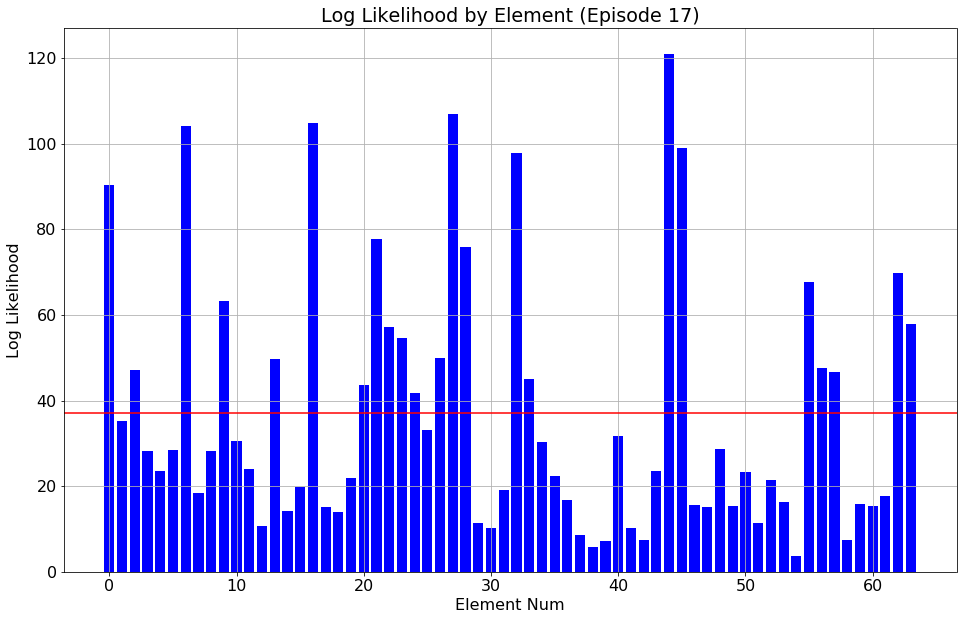

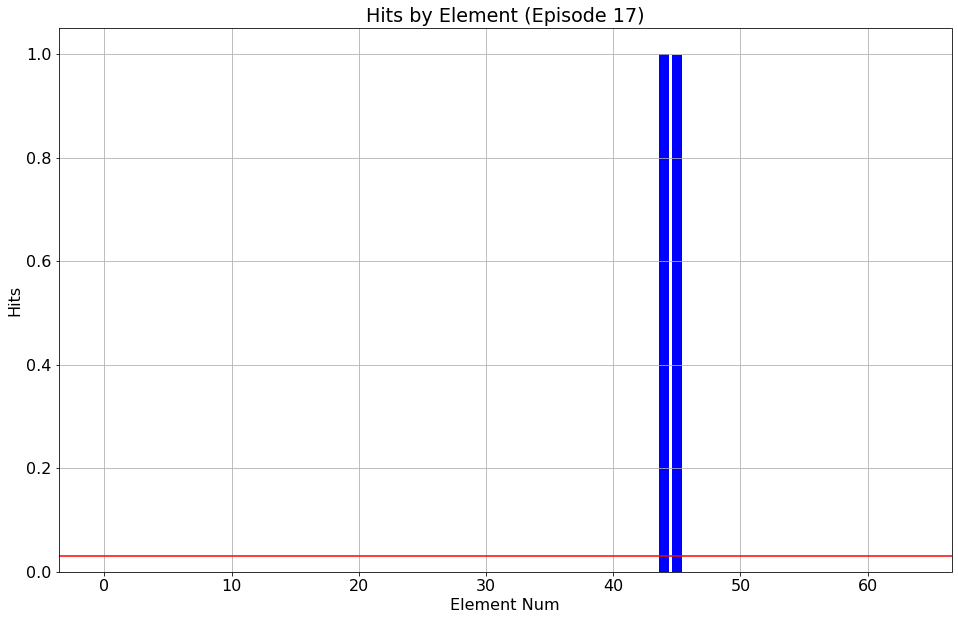


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 17: Epoch   68, Batch   4352
effective_learning_rate=2.441e-04, training_time 153 sec.
Train on 4096 samples
Epoch 69/72
4096/4096 [==============================] - 3s 829us/sample - loss: -815.8065
Epoch 70/72
4096/4096 [==============================] - 1s 357us/sample - loss: -841.6930
Epoch 71/72
4096/4096 [==============================] - 1s 350us/sample - loss: -860.1536
Epoch 72/72
4096/4096 [==============================] - 1s 350us/sample - loss: -874.6336
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    526.60 :   526.60 :      nan arc seconds
Geom Mean Threshold :   3600.00 :  3600.00 :      nan arc seconds
Mean Log Likelihood :     32.25 :    32.25 :      nan
Mean Hits           :      0

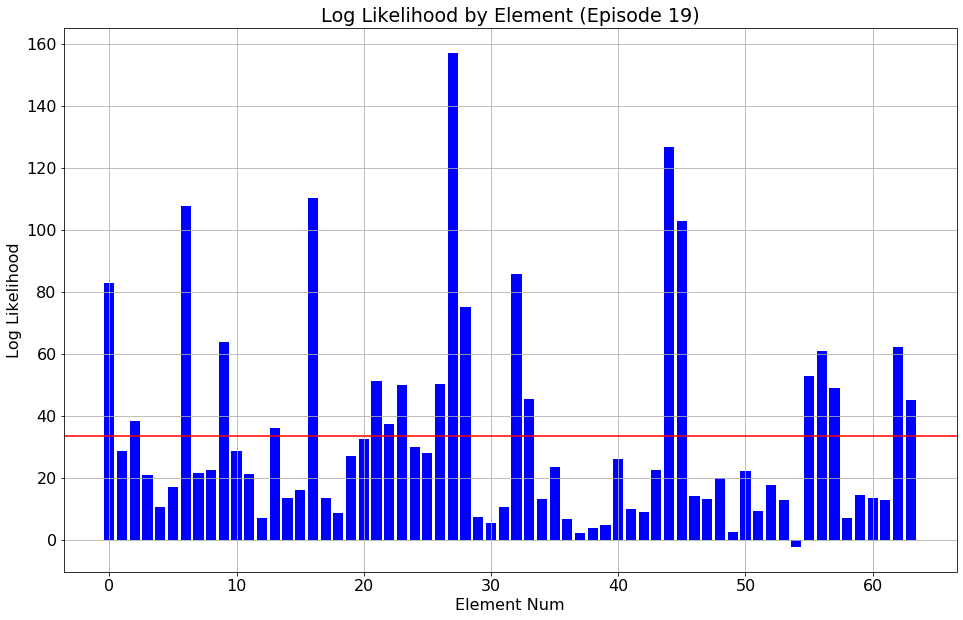

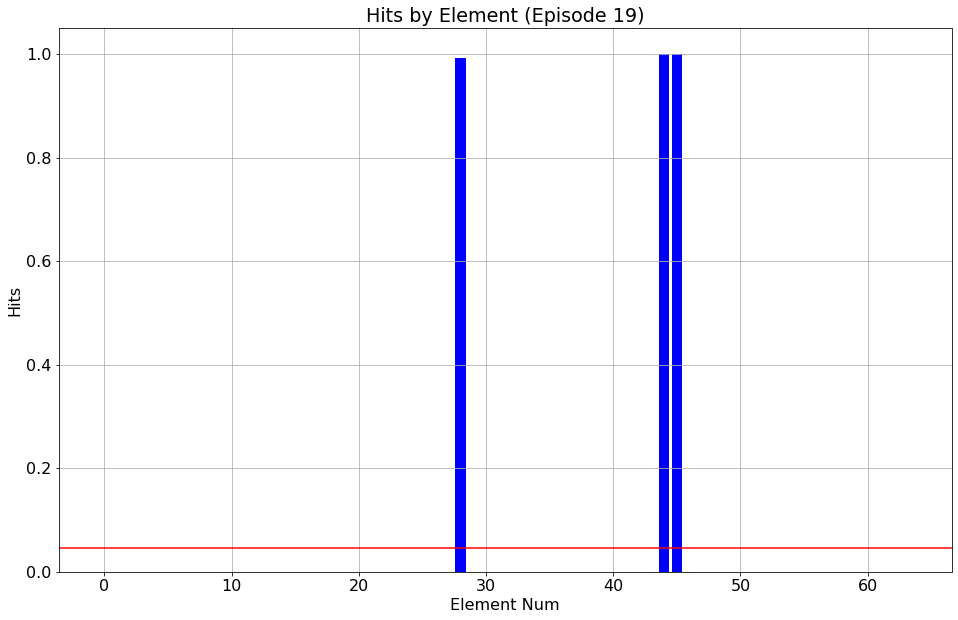


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 19: Epoch   76, Batch   4864
effective_learning_rate=2.308e-04, training_time 169 sec.
Train on 4096 samples
Epoch 77/80
4096/4096 [==============================] - 5s 1ms/sample - loss: -929.3809
Epoch 78/80
4096/4096 [==============================] - 2s 469us/sample - loss: -939.5921
Epoch 79/80
4096/4096 [==============================] - 2s 476us/sample - loss: -945.4166
Epoch 80/80
4096/4096 [==============================] - 2s 473us/sample - loss: -949.7799
Adjusted element weight down on 14 candidate elements. Mean weight = 1.01e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    506.66 :   506.66 :      nan arc seconds
Geom Mean Threshold :   3600.0

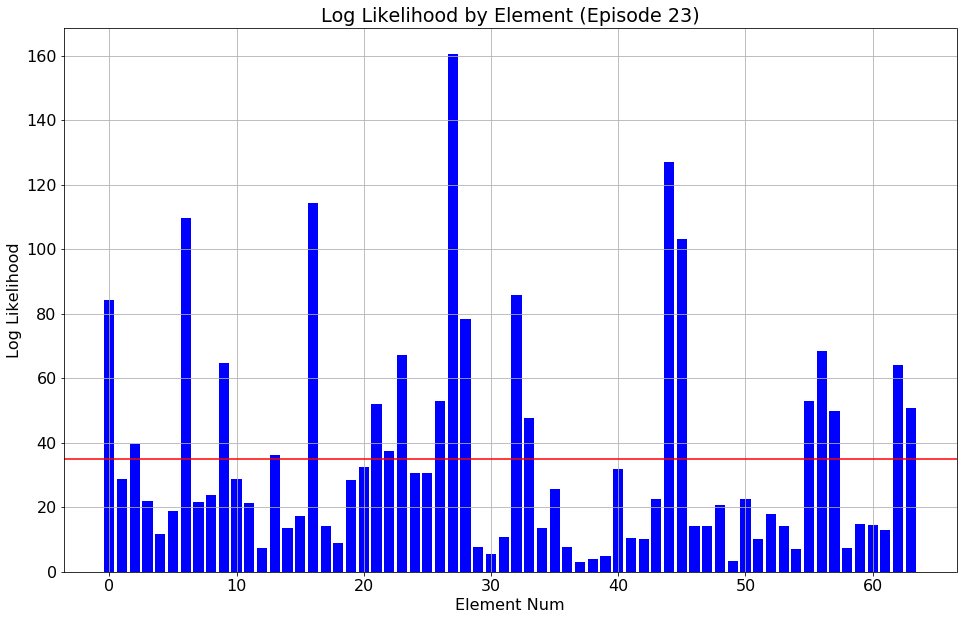

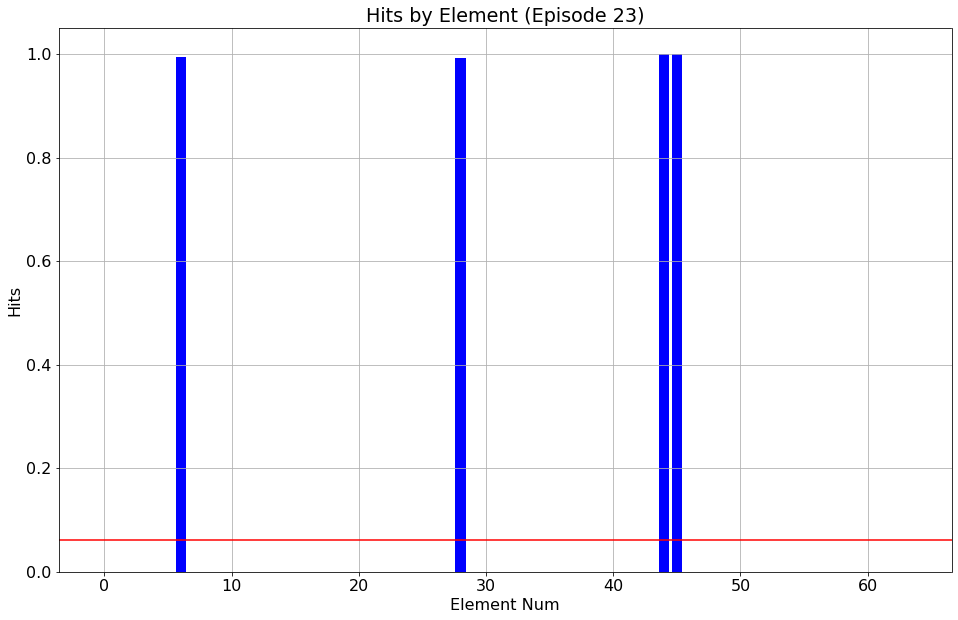


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 23: Epoch   92, Batch   5888
effective_learning_rate=2.441e-04, training_time 210 sec.
Train on 4096 samples
Epoch 93/96
4096/4096 [==============================] - 3s 836us/sample - loss: -775.0157
Epoch 94/96
4096/4096 [==============================] - 2s 374us/sample - loss: -787.2644
Epoch 95/96
4096/4096 [==============================] - 2s 371us/sample - loss: -796.3772
Epoch 96/96
4096/4096 [==============================] - 1s 366us/sample - loss: -803.2658
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    459.24 :   459.24 :      nan arc seconds
Geom Mean Threshold :   2400.00 :  2400.00 :      nan arc seconds
Mean Log Likelihood :     29.28 :    29.28 :      nan
Mean Hits           :      0

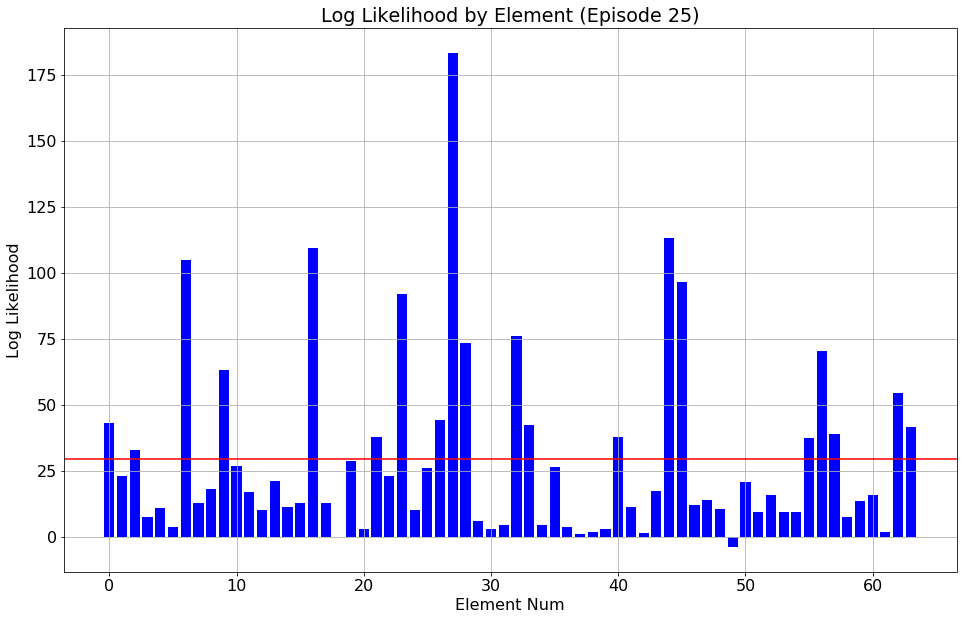

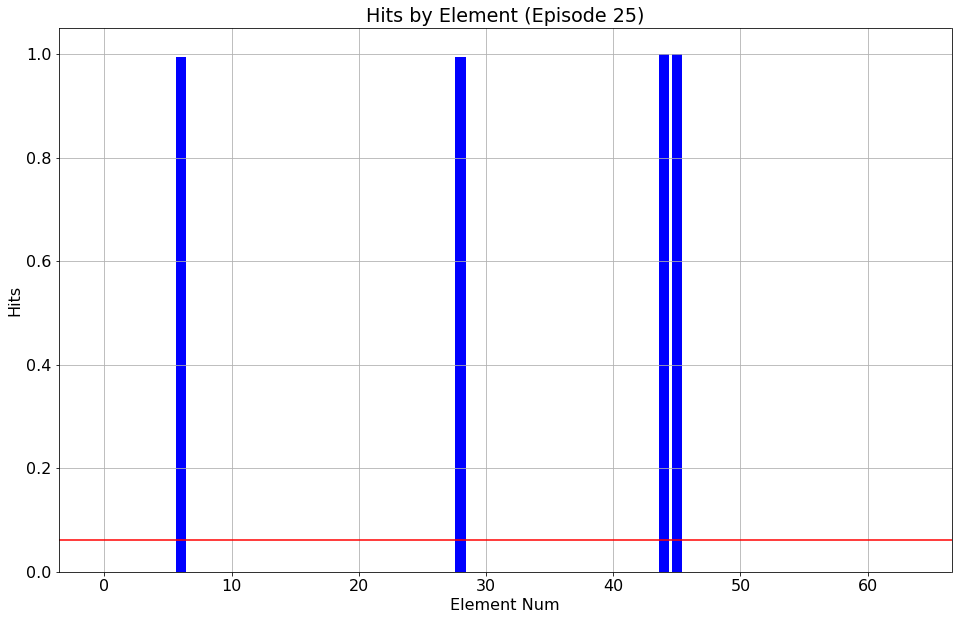


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 25: Epoch  100, Batch   6400
effective_learning_rate=2.193e-04, training_time 227 sec.
Train on 4096 samples
Epoch 101/104
4096/4096 [==============================] - 5s 1ms/sample - loss: -756.8900
Epoch 102/104
4096/4096 [==============================] - 2s 508us/sample - loss: -764.8980
Epoch 103/104
4096/4096 [==============================] - 2s 516us/sample - loss: -770.2157
Epoch 104/104
4096/4096 [==============================] - 2s 504us/sample - loss: -773.5212
Adjusted element weight down on 12 candidate elements. Mean weight = 1.16e-02
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    440.69 :   440.69 :      nan arc seconds
Geom Mean Threshold : 

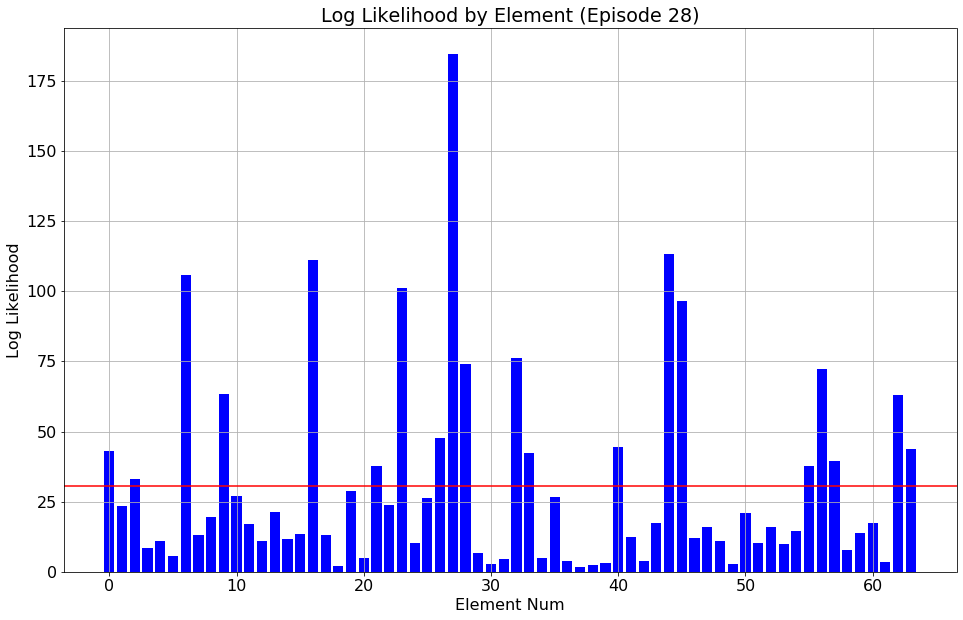

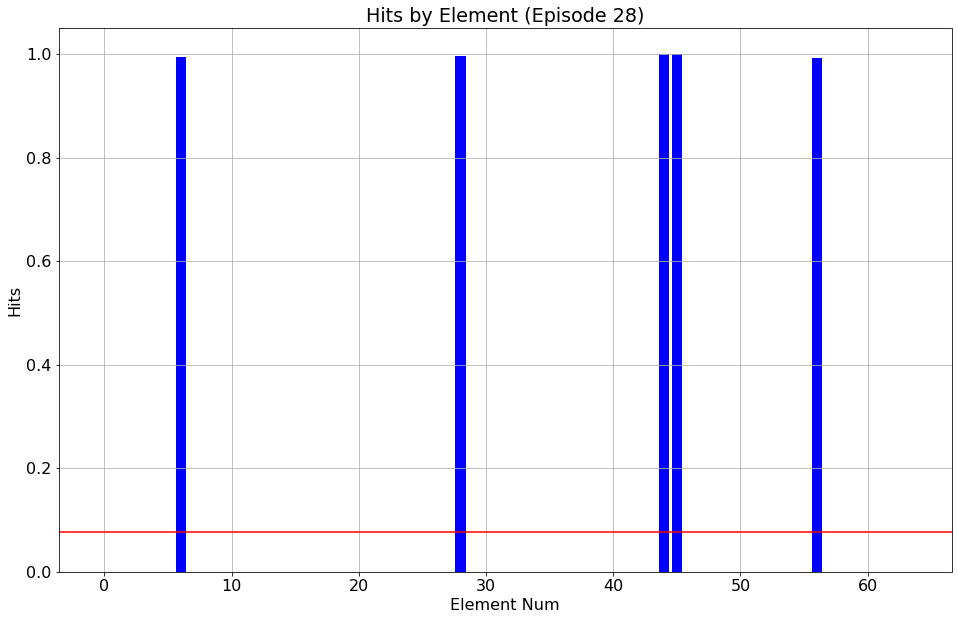


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 28: Epoch  112, Batch   7168
effective_learning_rate=1.221e-04, training_time 260 sec.
Train on 4096 samples
Epoch 113/116
4096/4096 [==============================] - 4s 879us/sample - loss: -838.4014
Epoch 114/116
4096/4096 [==============================] - 2s 392us/sample - loss: -841.0138
Epoch 115/116
4096/4096 [==============================] - 2s 394us/sample - loss: -843.0987
Epoch 116/116
4096/4096 [==============================] - 2s 398us/sample - loss: -844.8425
Adjusted element weight down on 20 candidate elements. Mean weight = 8.44e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    423.22 :   423.22 :      nan arc seconds
Geom Mean Threshol

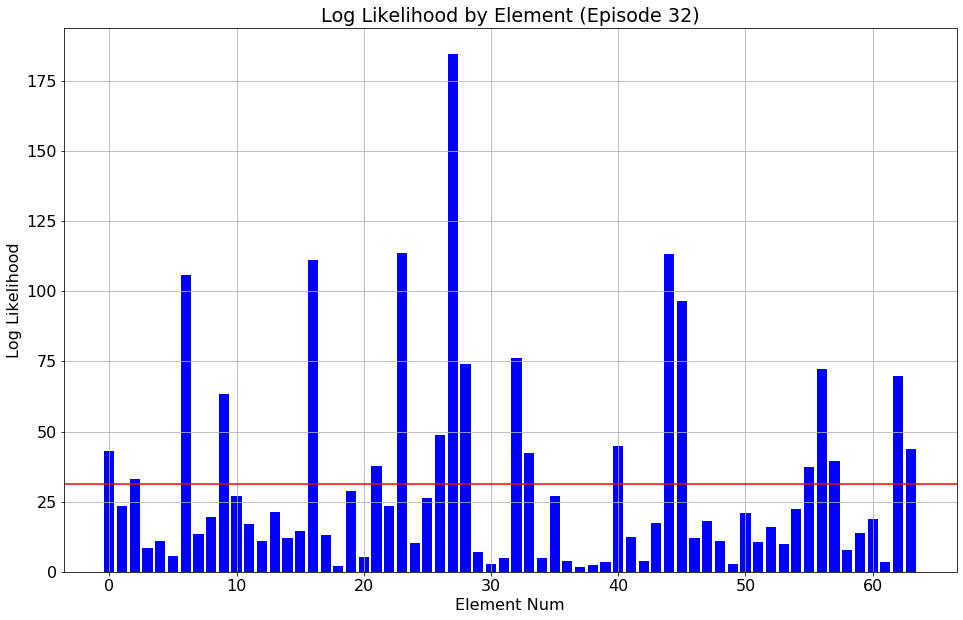

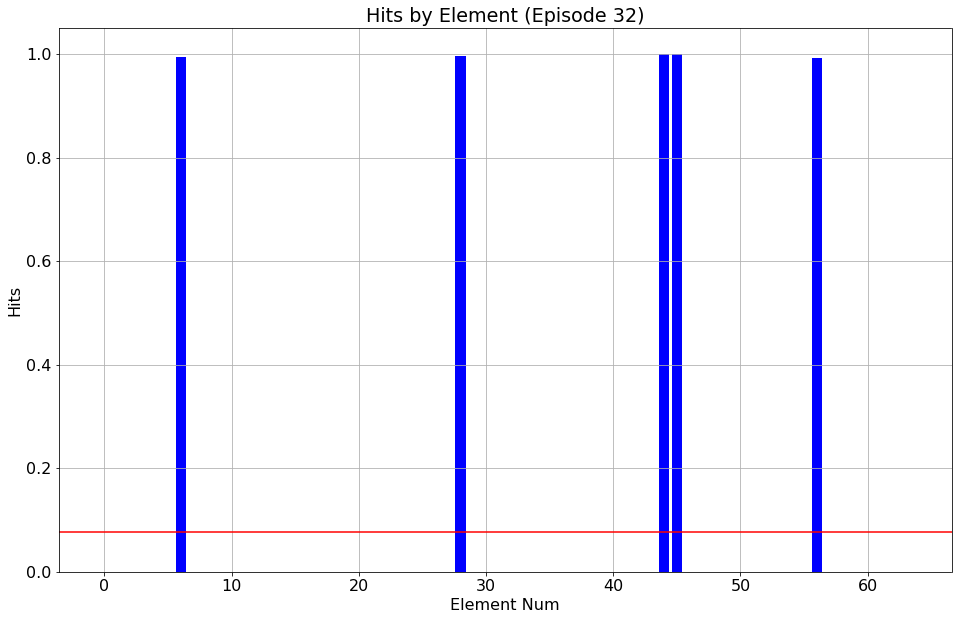


********************************************************************************
Round 6: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 32: Epoch  128, Batch   8192
effective_learning_rate=3.815e-06, training_time 292 sec.
Train on 4096 samples
Epoch 129/132
4096/4096 [==============================] - 5s 1ms/sample - loss: -360.9679
Epoch 130/132
4096/4096 [==============================] - 2s 527us/sample - loss: -364.1995
Epoch 131/132
4096/4096 [==============================] - 2s 530us/sample - loss: -366.8528
Epoch 132/132
4096/4096 [==============================] - 2s 529us/sample - loss: -368.4561
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    406.08 :   406.08 :      nan

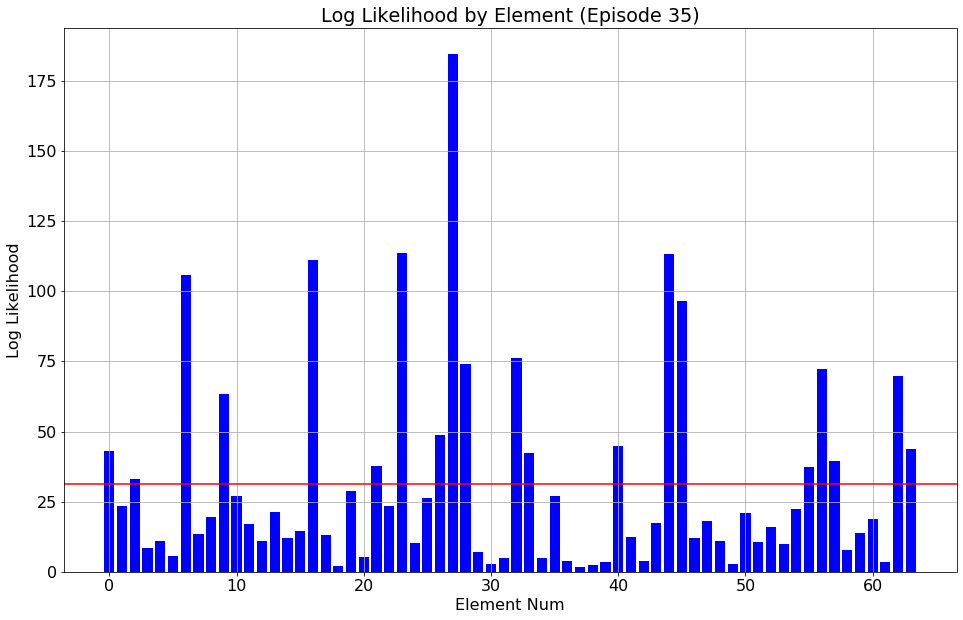

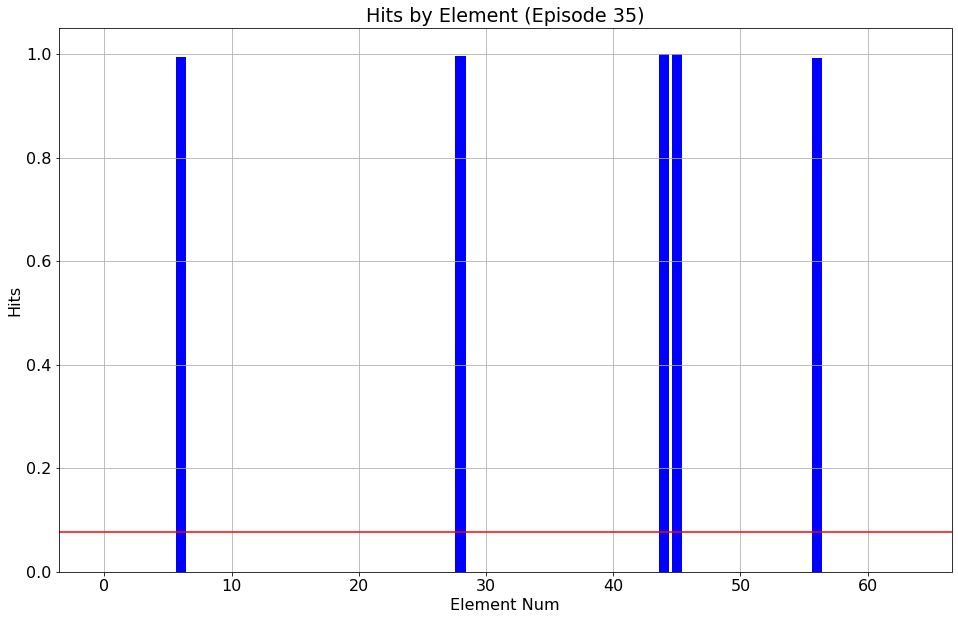


********************************************************************************
Round 7: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 35: Epoch  140, Batch   8960
effective_learning_rate=3.815e-06, training_time 326 sec.
Train on 4096 samples
Epoch 141/144
4096/4096 [==============================] - 5s 1ms/sample - loss: -356.4046
Epoch 142/144
4096/4096 [==============================] - 2s 551us/sample - loss: -359.5976
Epoch 143/144
4096/4096 [==============================] - 2s 547us/sample - loss: -362.2122
Epoch 144/144
4096/4096 [==============================] - 2s 556us/sample - loss: -363.7967
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    406.08 :   406.08 :      nan 

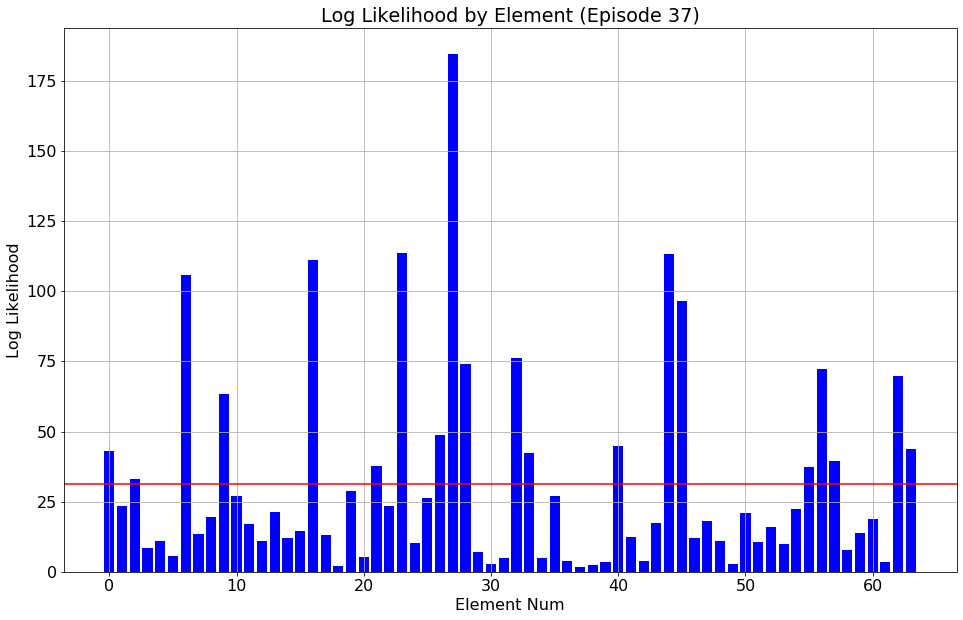

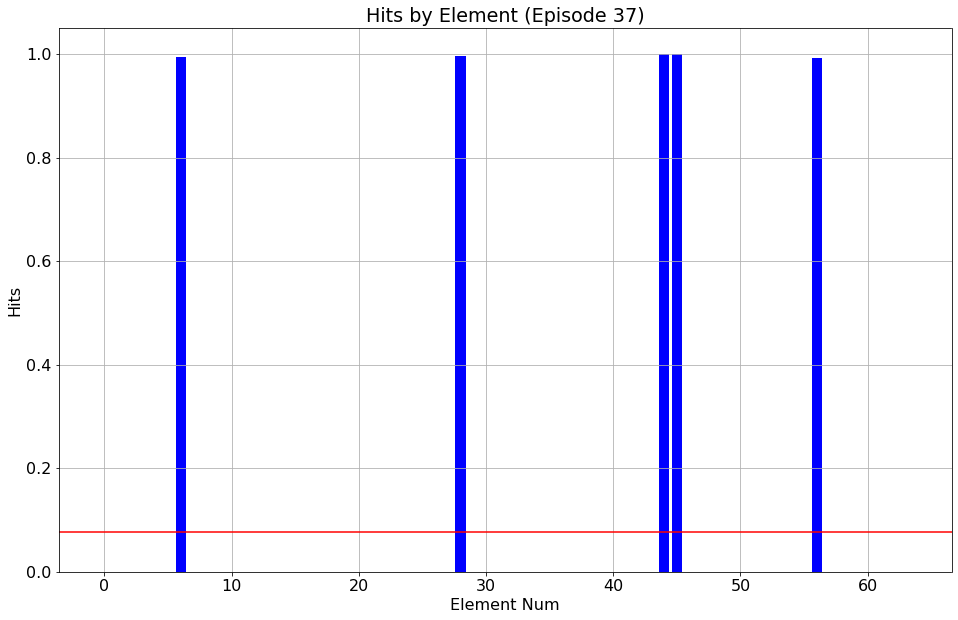

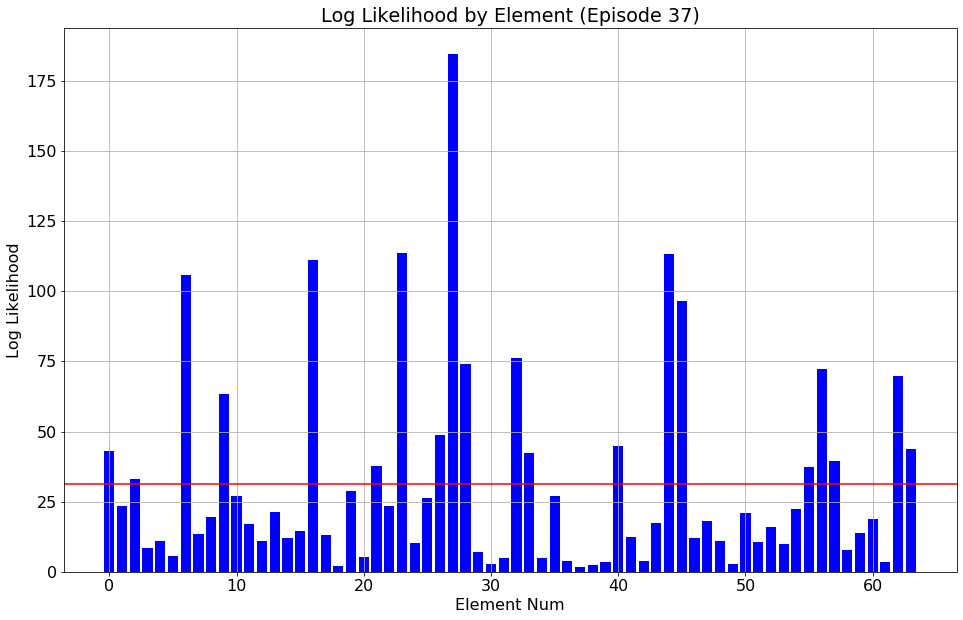

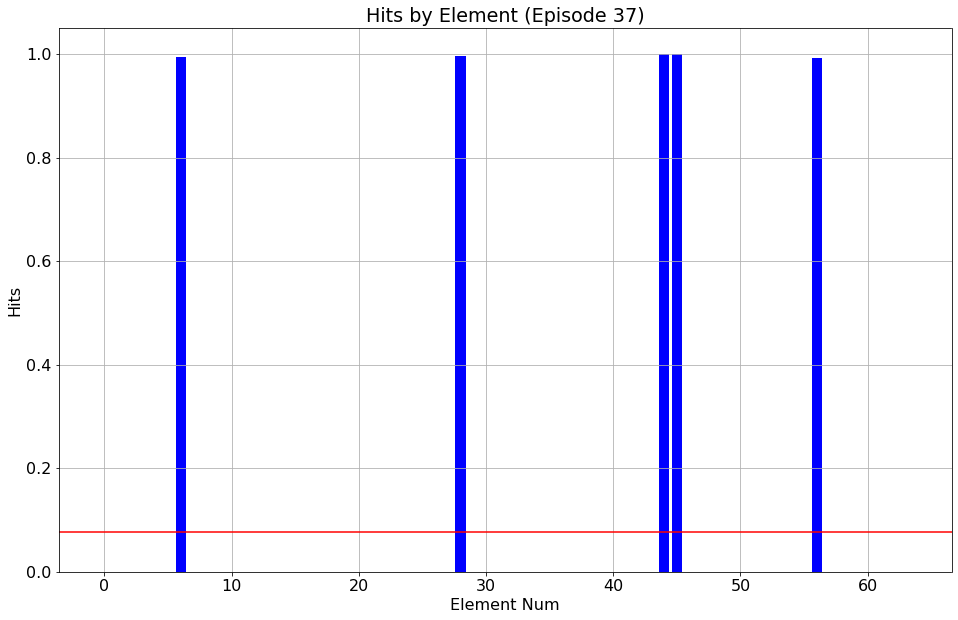

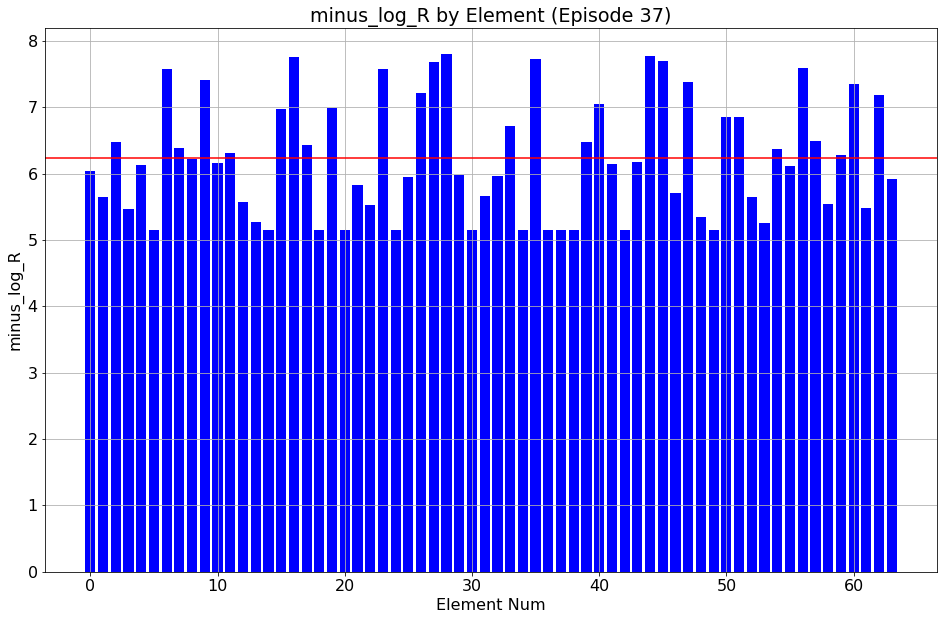

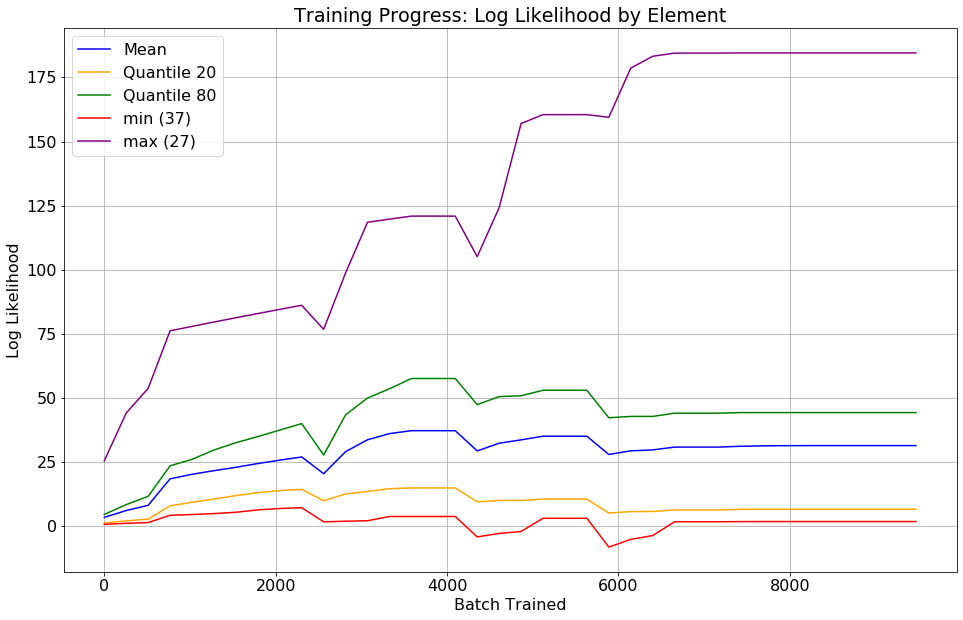

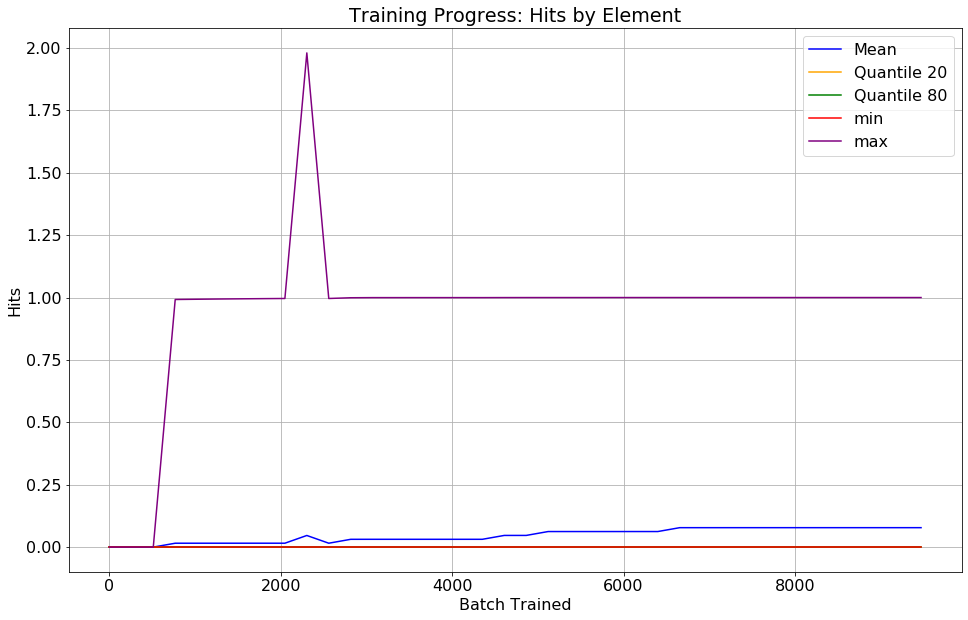

In [29]:
model.sieve(nearest_ast=False)

## Review Results Graphically

In [30]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [31]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [32]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [33]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [34]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

In [35]:
self = model

In [36]:
hist = self.train_hist_elt

In [37]:
hist

,key,element_num,element_id,episode,epoch,batch,training_time,log_like,hits,num_rows_close,...,e_,inc_,Omega_,omega_,f_,num_hits_,R_,weight_joint,weight_element,weight_mixture
0,0,0,0,0,0,0,0.000000,4.587205,0.0,1611.0,...,0.209350,0.535784,0.719583,0.362174,-0.054310,0.099876,0.914866,1.00,1.0,1.0000
1,1,1,1,0,0,0,0.000000,4.989374,0.0,1210.0,...,0.388701,0.530805,0.769292,0.130290,0.325593,0.099876,0.914866,1.00,1.0,1.0000
2,2,2,2,0,0,0,0.000000,3.687240,0.0,1481.0,...,0.084018,0.518359,0.623769,0.483271,-0.031973,0.099876,0.914866,1.00,1.0,1.0000
3,3,3,3,0,0,0,0.000000,4.902684,0.0,878.0,...,0.119381,0.534290,0.613487,0.546465,0.010461,0.099876,0.914866,1.00,1.0,1.0000
4,4,4,4,0,0,0,0.000000,1.773308,0.0,1550.0,...,0.247786,0.522249,0.627780,0.497724,-0.120127,0.099876,0.914866,1.00,1.0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,2427,59,59,37,148,9472,351.750778,13.738914,0.0,119.0,...,0.121796,0.531748,0.021325,0.020751,-0.012759,0.271675,0.840774,0.25,1.0,0.0625
2428,2428,60,60,37,148,9472,351.750778,18.710478,0.0,71.0,...,0.064471,0.525533,0.343327,0.606907,0.307068,0.110921,0.688440,0.25,1.0,1.0000
2429,2429,61,61,37,148,9472,351.750778,3.527520,0.0,37.0,...,0.209757,0.532767,0.212501,0.843105,0.335930,0.200921,0.953841,0.25,1.0,1.0000
2430,2430,62,62,37,148,9472,351.750778,69.825706,0.0,107.0,...,0.053684,0.604884,0.423273,0.338852,-0.679726,0.332431,0.712281,0.25,1.0,1.0000


In [38]:
episode = 4
mask = (hist.episode == episode)
elts = hist[mask]
elts

,key,element_num,element_id,episode,epoch,batch,training_time,log_like,hits,num_rows_close,...,e_,inc_,Omega_,omega_,f_,num_hits_,R_,weight_joint,weight_element,weight_mixture
256,256,0,0,4,16,1024,41.007365,46.326046,0.0,1464.0,...,0.208923,0.533004,0.723868,0.356655,-0.050564,0.255598,0.834286,1.0,1.0,1.0
257,257,1,1,4,16,1024,41.007365,25.750259,0.0,1068.0,...,0.389216,0.530607,0.768463,0.131186,0.325870,0.254618,0.844147,1.0,1.0,1.0
258,258,2,2,4,16,1024,41.007365,34.109035,0.0,1253.0,...,0.084004,0.519728,0.624586,0.483676,-0.031655,0.258049,0.822788,1.0,1.0,1.0
259,259,3,3,4,16,1024,41.007365,18.198994,0.0,838.0,...,0.122573,0.534649,0.607487,0.551237,0.010477,0.253053,0.838195,1.0,1.0,1.0
260,260,4,4,4,16,1024,41.007365,8.196324,0.0,1390.0,...,0.246501,0.520583,0.628928,0.498367,-0.120150,0.246527,0.887062,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,315,59,59,4,16,1024,41.007365,9.352498,0.0,830.0,...,0.143483,0.531235,0.014209,0.026788,-0.012064,0.189401,0.783086,1.0,1.0,1.0
316,316,60,60,4,16,1024,41.007365,11.405470,0.0,437.0,...,0.076740,0.525970,0.345010,0.607662,0.305166,0.223182,0.825236,1.0,1.0,1.0
317,317,61,61,4,16,1024,41.007365,22.145176,0.0,101.0,...,0.204566,0.531844,0.213076,0.849807,0.328871,0.226093,0.883200,1.0,1.0,1.0
318,318,62,62,4,16,1024,41.007365,23.509665,0.0,351.0,...,0.076301,0.605542,0.421970,0.341328,-0.676534,0.243591,0.907984,1.0,1.0,1.0


In [39]:
summary = self.train_hist_summary

In [40]:
summary

,key,episode,epoch,batch,training_time,loss,learning_rate,log_like_mean,log_like_med,log_like_std,...,thresh_sec_q20,thresh_sec_q80,log_thresh_mean,log_thresh_std,log_thresh_min,log_thresh_max,log_thresh_q20,log_thresh_q80,candidate_elements_trainable,mixture_parameters_trainable
0,0,0,0,0,0.000000,47352.0,0.000244,3.331696,2.005517,4.010924,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,False,True
1,1,1,4,256,16.955810,47352.0,0.000244,5.997301,3.195203,7.204620,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,False,True
2,2,2,8,512,21.820430,47352.0,0.000015,8.027000,3.888911,9.889592,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
3,3,3,12,768,32.989830,41608.0,0.000015,18.367376,13.719882,14.294212,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
4,4,4,16,1024,41.007365,41071.0,0.000015,20.138021,15.511965,14.755482,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
5,5,5,20,1280,49.054260,40819.0,0.000015,21.542656,16.416512,15.308589,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
6,6,6,24,1536,57.059450,40554.0,0.000015,22.863890,16.907932,15.796896,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
7,7,7,28,1792,65.362900,40211.0,0.000015,24.335251,18.354053,16.191149,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
8,8,8,32,2048,73.637785,40057.0,0.000015,25.642494,19.377987,16.569668,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
9,9,9,36,2304,81.966919,39907.0,0.000015,26.897562,20.428408,16.972300,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True


In [41]:
episode = 4
mask = (summary.episode <= episode)

In [42]:
summary[mask]

,key,episode,epoch,batch,training_time,loss,learning_rate,log_like_mean,log_like_med,log_like_std,...,thresh_sec_q20,thresh_sec_q80,log_thresh_mean,log_thresh_std,log_thresh_min,log_thresh_max,log_thresh_q20,log_thresh_q80,candidate_elements_trainable,mixture_parameters_trainable
0,0,0,0,0,0.000000,47352.0,0.000244,3.331696,2.005517,4.010924,...,7199.998535,7199.998535,-3.355131,0.0,-3.355131,-3.355131,-3.355131,-3.355131,False,True
1,1,1,4,256,16.955810,47352.0,0.000244,5.997301,3.195203,7.204620,...,7199.998535,7199.998535,-3.355131,0.0,-3.355131,-3.355131,-3.355131,-3.355131,False,True
2,2,2,8,512,21.820430,47352.0,0.000015,8.027000,3.888911,9.889592,...,7199.998535,7199.998535,-3.355131,0.0,-3.355131,-3.355131,-3.355131,-3.355131,True,True
3,3,3,12,768,32.989830,41608.0,0.000015,18.367376,13.719882,14.294212,...,7199.998535,7199.998535,-3.355131,0.0,-3.355131,-3.355131,-3.355131,-3.355131,True,True
4,4,4,16,1024,41.007365,41071.0,0.000015,20.138021,15.511965,14.755482,...,7199.998535,7199.998535,-3.355131,0.0,-3.355131,-3.355131,-3.355131,-3.355131,True,True


In [43]:
idx = summary.index[summary.epoch == epoch][0]
idx

NameError: name 'epoch' is not defined

In [ ]:
summary.episode.loc[idx]